# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
#Se importan las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Se importa el DataSet
data = pd.read_csv('taxi.csv')

In [3]:
#Se imprime una muestra del DataSet
print(data.head())

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


In [4]:
#Se imprime la informacion del DataSet
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


##### Se puede observar que el tipo de dato de datetime no corresponde a datetime64 por lo que se debe cambiar su tipo de datos

## Análisis

In [5]:
#Se transforma el tipo de datos de datetime a datetime64
data['datetime'] = pd.to_datetime(data['datetime'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


In [6]:
#Se remuestrean los datos a intervalos de 1 hora sumando los pedidos
data_resample = data.set_index('datetime').resample('1h').sum()

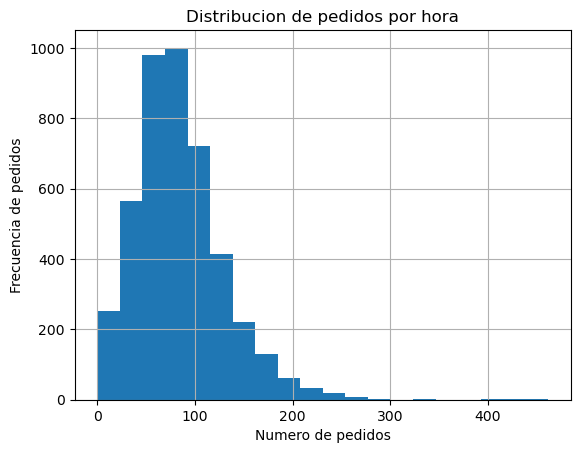

In [7]:
#Se crea un histograma de distribucion de pedidos de taxi por hora

data_resample['num_orders'].hist(bins=20)
plt.title('Distribucion de pedidos por hora')
plt.xlabel('Numero de pedidos')
plt.ylabel('Frecuencia de pedidos')

plt.show()

##### La distribucion del histograma es asimetrica a la derecha, lo que significa que hay algunas horas con un numero de pedidos muy alto, pero la mayoria de datos esta concentrado en el lado mas bajo que es cercano a 100 pedidos

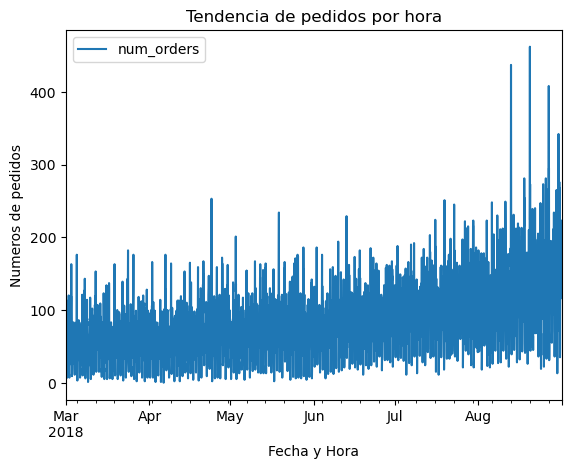

In [8]:
data_resample.plot(y='num_orders',
                   kind = 'line',
                   title = 'Tendencia de pedidos por hora',
                   xlabel = 'Fecha y Hora',
                   ylabel = 'Numeros de pedidos')

plt.show()


##### Se observa una tendencia ascendente en el numero de pedidos a medida que avanza el tiempo, es decir la demanda de pedidos aumenta constantemente.

##### Se observa que hay muchas fluctuaciones en los pedidos por hora, algunas horas tienen picos altos y otras picos bajos, lo que puede deberse a una mayor actividad en horas pico, días especificos de la semana.

## Formación

In [16]:
#Se crea una funcion para crear caracteristica para nuestros datos y mejorar el entrenamiento
def make_features(data_resample, max_lag, rolling_mean_size):
    data_resample['year'] = data_resample.index.year
    data_resample['month'] = data_resample.index.month
    data_resample['day'] = data_resample.index.day
    data_resample['hour'] = data_resample.index.hour
    data_resample['minutes'] = data_resample.index.minute
    data_resample['seconds'] = data_resample.index.second
    
    for lag in range(1, max_lag+1):
        data_resample['lag_{}'.format(lag)] = data_resample['num_orders'].shift(lag)
        
    data_resample['rolling_mean'] = data_resample['num_orders'].shift().rolling(rolling_mean_size).mean() 
    
make_features(data_resample, 5, 5)

In [17]:
#Se imprime los datos con las caracteristicas nuevas
print(data_resample.head())

                     num_orders  year  month  day  hour  minutes  seconds  \
datetime                                                                    
2018-03-01 00:00:00         124  2018      3    1     0        0        0   
2018-03-01 01:00:00          85  2018      3    1     1        0        0   
2018-03-01 02:00:00          71  2018      3    1     2        0        0   
2018-03-01 03:00:00          66  2018      3    1     3        0        0   
2018-03-01 04:00:00          43  2018      3    1     4        0        0   

                     lag_1  lag_2  lag_3  lag_4  lag_5  rolling_mean  
datetime                                                              
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN           NaN  
2018-03-01 01:00:00  124.0    NaN    NaN    NaN    NaN           NaN  
2018-03-01 02:00:00   85.0  124.0    NaN    NaN    NaN           NaN  
2018-03-01 03:00:00   71.0   85.0  124.0    NaN    NaN           NaN  
2018-03-01 04:00:00   66.0   71.0 

In [18]:
#Se divide los datos en train y test
train, test = train_test_split(data_resample, shuffle=False, test_size=0.10, random_state=1111)
train = train.dropna()

#Se obtienen las caracteristicas y objetivos para el entrenamiento
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

## Prueba

In [19]:
#Se entrena el modelo con regresion lineal
lineal_model = LinearRegression()
lineal_model.fit(features_train, target_train)

pred_train_lineal = lineal_model.predict(features_train)
pred_test_lineal = lineal_model.predict(features_test)

print('EAM para el conjunto de entrenamiento en regresion lineal:', mean_squared_error(target_train, pred_train_lineal))
print('EAM para el conjunto de prueba en regresion lineal:', mean_squared_error(target_test, pred_test_lineal))


EAM para el conjunto de entrenamiento en regresion lineal: 929.9069793162079
EAM para el conjunto de prueba en regresion lineal: 2775.989694072087


In [20]:
#Se entrena el modelo con árbol de decision
tree_model = DecisionTreeRegressor(random_state=1111)
tree_model.fit(features_train, target_train)

pred_train_tree = tree_model.predict(features_train)
pred_test_tree = tree_model.predict(features_test)

print('EAM para el conjunto de entrenamiento:', mean_squared_error(target_train, pred_train_tree))
print('EAM para el conjunto de prueba:', mean_squared_error(target_test, pred_test_tree))


EAM para el conjunto de entrenamiento: 0.0
EAM para el conjunto de prueba: 3330.9615384615386


In [21]:
#Se entrena el modelo con bosque aleatorio
forest_model = RandomForestRegressor(n_estimators=300, max_depth=10,min_samples_leaf=5, min_samples_split=10, random_state=1111)
forest_model.fit(features_train, target_train)

pred_train_forest = forest_model.predict(features_train)
pred_test_forest = forest_model.predict(features_test)

print('EAM para el conjunto de entrenamiento:', mean_squared_error(target_train, pred_train_forest))
print('EAM para el conjunto de prueba:', mean_squared_error(target_test, pred_test_forest))



EAM para el conjunto de entrenamiento: 308.0381858528272
EAM para el conjunto de prueba: 2272.763784967542


# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48